2025-04-14 15:21:04.362184: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/opt/cray/pe/papi/6.0.0.14/lib64:/opt/cray/libfabric/1.11.0.4.125/lib64
2025-04-14 15:21:04.362216: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


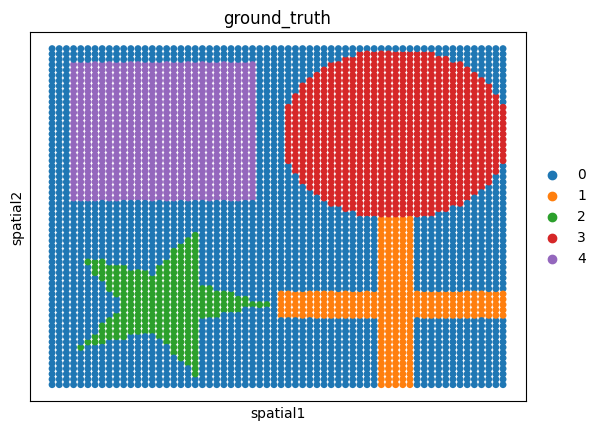

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Enhanced spatial simulation with multi-omics data generation
"""
import random
import os
import numpy as np
from pandas import get_dummies
from anndata import AnnData
from scipy.stats import norm, poisson
from pathlib import Path
dtp = "float32"
random.seed(101)
import scanpy as sc
import sys
sys.path.append("/home/project/11003054/changxu/Projects/DIRAC/Section-2/nsf-paper-main")
from utils import misc, preprocess

# Enhanced pattern generation functions
def squares(size=12):
    """Generate square patterns of given size"""
    A = np.zeros([size,size])
    quarter = size//4
    A[quarter:3*quarter, quarter:3*quarter] = 1
    return A

def circles(size=12):
    """Generate circle patterns of given size"""
    A = np.zeros((size, size))
    center = size//2
    radius = size//3
    for i in range(size):
        for j in range(size):
            if (i - center)**2 + (j - center)**2 < radius**2:
                A[i, j] = 1
    return A

def triangles(size=12):
    """Generate triangle patterns of given size"""
    A = np.zeros((size, size))
    for i in range(size):
        A[i, :i+1] = 1
    return A

def stripes(size=12, orientation='horizontal'):
    """Generate stripe patterns"""
    A = np.zeros((size, size))
    if orientation == 'horizontal':
        for i in range(0, size, 2):
            A[i, :] = 1
    else:  # vertical
        for j in range(0, size, 2):
            A[:, j] = 1
    return A

def checkerboards(size=12):
    """Generate checkerboard patterns"""
    A = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if (i + j) % 2 == 0:
                A[i, j] = 1
    return A

def crosses(size=12):
    """Generate cross patterns"""
    A = np.zeros((size, size))
    center = size//2
    thickness = max(1, size//6)
    A[center-thickness:center+thickness, :] = 1
    A[:, center-thickness:center+thickness] = 1
    return A


def ggblocks(nside=64, block_size = 32):
    """
    Generate large blocky spatial patterns where each pattern is a separate class.
    Includes a five-pointed star pattern.
    - Each pattern occupies a distinct block in the spatial grid
    - block_size must divide nside
    - Returns: (num_patterns, nside*nside) array where each row is one pattern
    """
    if nside % block_size != 0:
        raise ValueError("nside must be divisible by block_size")

    n_blocks = nside // block_size
    num_patterns = min(4, n_blocks**2)  # We'll generate up to 4 distinct patterns

    # Define pattern generators (expanded to 12 patterns)
    def square_pattern(size):
        A = np.zeros((size, size))
        q = size // 10
        A[q:-q, q:-q] = 1
        return A

    def cross_pattern(size, thickness=5):
        A = np.zeros((size, size))
        c = size // 2
        half_thickness = thickness // 2
        start = c - half_thickness
        end = c + half_thickness + (thickness % 2)
        start = max(0, start)
        end = min(size, end)
        A[:, start:end] = 1
        A[start:end, :] = 1
        return A

    def diag_pattern(size):
        A = np.eye(size)
        A += np.fliplr(np.eye(size))
        return (A > 0).astype(float)

    def circle_pattern(size):
        A = np.zeros((size, size))
        r = size // 2
        cx, cy = size // 2, size // 2
        for i in range(size):
            for j in range(size):
                if (i - cx) ** 2 + (j - cy) ** 2 < r ** 2:
                    A[i, j] = 1
        return A

    def star_pattern(size):
        A = np.zeros((size, size))
        center = size // 2
        radius = size // 2 - 2
        angles = np.linspace(0, 2*np.pi, 6)[:-1]
        star_points = []
        for i, angle in enumerate(angles):
            x = center + radius * np.cos(angle)
            y = center + radius * np.sin(angle)
            star_points.append((x, y))
            inner_angle = angle + 2*np.pi/10
            x = center + (radius/2.5) * np.cos(inner_angle)
            y = center + (radius/2.5) * np.sin(inner_angle)
            star_points.append((x, y))
        star_points = np.array(star_points).astype(int)
        from matplotlib.path import Path
        x, y = np.meshgrid(np.arange(size), np.arange(size))
        points = np.vstack((x.flatten(), y.flatten())).T
        path = Path(star_points)
        mask = path.contains_points(points)
        A = mask.reshape(size, size).astype(float)
        return A

    def spiral_pattern(size):
        A = np.zeros((size, size))
        center = size // 2
        for i in range(size):
            for j in range(size):
                r = np.sqrt((i - center)**2 + (j - center)**2)
                theta = np.arctan2(j - center, i - center)
                if r < center and np.sin(5 * theta + r) > 0.5:
                    A[i, j] = 1
        return A

    def heart_pattern(size):
        A = np.zeros((size, size))
        center = size // 2
        scale = size / 4
        for i in range(size):
            for j in range(size):
                x = (i - center) / scale
                y = (j - center) / scale
                if (x**2 + y**2 - 1)**3 - x**2 * y**3 < 0:
                    A[i, j] = 1
        return A

    def maze_pattern(size):
        A = np.zeros((size, size))
        for i in range(size):
            for j in range(size):
                if (i % 4 == 0) or (j % 4 == 0 and (i // 4 + j // 4) % 2 == 0):
                    A[i, j] = 1
        return A

    def concentric_circles(size):
        A = np.zeros((size, size))
        center = size // 2
        for i in range(size):
            for j in range(size):
                r = np.sqrt((i - center)**2 + (j - center)**2)
                if r % 5 < 2.5:
                    A[i, j] = 1
        return A

    def checkerboard_large(size):
        A = np.zeros((size, size))
        for i in range(size):
            for j in range(size):
                if (i // 3 + j // 3) % 2 == 0:
                    A[i, j] = 1
        return A

    def stripes_diagonal(size):
        A = np.zeros((size, size))
        for i in range(size):
            for j in range(size):
                if (i + j) % 4 < 2:
                    A[i, j] = 1
        return A

    def dots_pattern(size):
        A = np.zeros((size, size))
        for i in range(2, size, 5):
            for j in range(2, size, 5):
                A[i, j] = 1
        return A
        
    def crescent_moon(size):
        A = np.zeros((size, size))
        center = size // 2
        outer_r = size // 2 - 2
        inner_r = outer_r - size // 5
        for i in range(size):
            for j in range(size):
                d = np.sqrt((i-center)**2 + (j-center)**2)
                angle = np.arctan2(j-center, i-center)
                if d < outer_r and not (d < inner_r and angle > -np.pi/2 and angle < np.pi/2):
                    A[i,j] = 1
        return A

    def fibonacci_spiral(size):
        A = np.zeros((size, size))
        center = size // 2
        scale = size / 3    
        phi = (1 + np.sqrt(5)) / 2  
        golden_angle = 2 * np.pi * (2 - phi)  
        n_points = 100 
        angles = golden_angle * np.arange(n_points)  
        radii = scale * np.sqrt(np.arange(n_points) / np.sqrt(n_points)) 
        points = np.array([
            center + radii * np.cos(angles),
            center + radii * np.sin(angles)
        ]).T.astype(int)

        for i in range(len(points)-1):
            x1, y1 = points[i]
            x2, y2 = points[i+1]
            steps = max(abs(x2-x1), abs(y2-y1)) + 1
            for t in np.linspace(0, 1, steps):
                x = int(round(x1 + t*(x2-x1)))
                y = int(round(y1 + t*(y2-y1)))
                if 0 <= x < size and 0 <= y < size:
                    A[x, y] = 1      
        return A

    def cellular_automata(size, rule=30, random_init=True):
        A = np.zeros((size, size), dtype=int)

        if random_init:
            A[0, :] = np.random.randint(0, 2, size)
        else:
            A[0, size//2] = 1  

        rule_bits = np.array([int(b) for b in f"{rule:08b}"[::-1]])
    
        for i in range(1, size):
            for j in range(size):
                left = A[i-1, (j-1)%size]
                center = A[i-1, j]
                right = A[i-1, (j+1)%size]
                neighborhood = (left << 2) | (center << 1) | right
                A[i, j] = rule_bits[neighborhood]
    
        return A

    def fractal_tree(size):
        A = np.zeros((size, size))
        start_x, start_y = size//2, size-5
        branch_length = size // 3
        
        def draw_branch(x, y, length, angle, thickness):
            if length < 2:
                return
            end_x = x - length * np.sin(angle)
            end_y = y - length * np.cos(angle)
            steps = max(abs(int(end_x-x)), abs(int(end_y-y))) + 1
            for t in np.linspace(0, 1, steps):
                tx = x + t*(end_x-x)
                ty = y + t*(end_y-y)
                for dx in range(-thickness, thickness+1):
                    for dy in range(-thickness, thickness+1):
                        nx, ny = int(tx+dx), int(ty+dy)
                        if 0 <= nx < size and 0 <= ny < size:
                            A[nx, ny] = 1
            new_length = length * 0.7
            new_thickness = max(1, thickness-1)
            draw_branch(end_x, end_y, new_length, angle-np.pi/5, new_thickness)
            draw_branch(end_x, end_y, new_length, angle+np.pi/5, new_thickness)
        
        draw_branch(start_x, start_y, branch_length, 0, 2)
        return A

    # Replace circle pattern with star pattern
    patterns = [
        square_pattern, 
        circle_pattern, 
        star_pattern, 
        cross_pattern,
        # spiral_pattern,
        # heart_pattern,
        # maze_pattern,
        # diag_pattern,
        # concentric_circles,
        # checkerboard_large,
        # stripes_diagonal,
        # dots_pattern,
        # crescent_moon,      
        # fibonacci_spiral,   
        # cellular_automata,  
        # fractal_tree,        
    ]
    
    # Initialize output array (num_patterns, nside*nside)
    output = np.zeros((num_patterns, nside*nside))

    for pattern_idx in range(num_patterns):
        # Create empty grid for this pattern
        grid = np.zeros((nside, nside))
        
        # Calculate block position for this pattern
        row = pattern_idx // n_blocks
        col = pattern_idx % n_blocks
        
        # Only place this pattern in its designated block
        if row < n_blocks and col < n_blocks:
            start_x = row * block_size
            start_y = col * block_size
            block_pattern = patterns[pattern_idx % len(patterns)](block_size)
            grid[start_x:start_x+block_size, start_y:start_y+block_size] = block_pattern
        
        # Store this pattern's grid
        output[pattern_idx, :] = grid.flatten()

    return output


def quilt(size=12):
    """Original quilt patterns"""
    patterns = [
        squares(size),
        crosses(size),
        circles(size),
        triangles(size)
    ]
    L = len(patterns)
    pattern_size = patterns[0].size
    A = np.zeros([L, pattern_size])
    for i, pattern in enumerate(patterns):
        A[i, :] = pattern.flatten()
    return A

def sqrt_int(x):
    z = int(round(x**.5))
    if x == z**2:
        return z
    else:
        raise ValueError("x must be a square integer")

def gen_spatial_factors(scenario="quilt", nside=36):
    """
    Generate spatial factors for different scenarios
    """
    if scenario == "quilt":
        A = quilt()
    elif scenario == "ggblocks":
        A = ggblocks(nside)
    elif scenario == "both":
        A1 = quilt()
        A2 = ggblocks(nside)
        A = np.vstack((A1, A2))
    else:
        raise ValueError("scenario must be 'quilt', 'ggblocks' or 'both'")
    
    unit = sqrt_int(A.shape[1])
    assert nside % unit == 0
    ncopy = nside // unit
    N = nside**2
    L = A.shape[0]
    A = A.reshape((L, unit, unit))
    A = np.kron(A, np.ones((1, ncopy, ncopy)))
    F = A.reshape((L, N)).T
    return F

def gen_spatial_coords(N):
    """Generate spatial coordinates"""
    X = misc.make_grid(N)
    X[:, 1] = -X[:, 1]  # make the display the same
    return preprocess.rescale_spatial_coords(X)

def gen_nonspatial_factors(N, L=3, nzprob=0.2, seed=101):
    """Generate non-spatial factors"""
    rng = np.random.default_rng(seed)
    return rng.binomial(1, nzprob, size=(N, L))

def gen_loadings(Lsp, Lns=3, Jsp=0, Jmix=500, Jns=0, 
                 expr_mean=20.0, mix_frac_spat=0.1, 
                 modality='RNA', seed=101):
    """
    Generate loadings matrix for different modalities
    """
    rng = np.random.default_rng(seed)
    J = Jsp + Jmix + Jns
    
    # Adjust parameters based on modality
    if modality == 'ADT':
        expr_mean = expr_mean  # ADT typically has higher counts
        mix_frac_spat = 0.5  # ADT often more spatially structured
    elif modality == 'ATAC':
        expr_mean = expr_mean  # ATAC typically has lower counts
        mix_frac_spat = 0.5  # Chromatin accessibility may be less spatially structured
    
    if Lsp > 0:
        w = rng.choice(Lsp, J, replace=True)
        W = get_dummies(w).to_numpy(dtype=dtp)
    else:
        W = np.zeros((J, 0))
    
    if Lns > 0:
        v = rng.choice(Lns, J, replace=True)
        V = get_dummies(v).to_numpy(dtype=dtp)
    else:
        V = np.zeros((J, 0))
    
    # Pure spatial features
    W[:Jsp, :] *= expr_mean
    V[:Jsp, :] = 0
    
    # Mixed features
    W[Jsp:(Jsp+Jmix), :] *= (mix_frac_spat * expr_mean)
    V[Jsp:(Jsp+Jmix), :] *= ((1 - mix_frac_spat) * expr_mean)
    
    # Pure non-spatial features
    W[(Jsp+Jmix):, :] = 0
    V[(Jsp+Jmix):, :] *= expr_mean
    
    return W, V

def add_gaussian_noise(data, snr=20, seed=101):
    """Add Gaussian noise to data with specified signal-to-noise ratio"""
    rng = np.random.default_rng(seed)
    signal_power = np.mean(data**2)
    noise_power = signal_power / snr
    noise = rng.normal(0, np.sqrt(noise_power), data.shape)
    return data + noise

# def add_gaussian_noise(data, mean=2, variance=0.5, seed=101):
#     """Add Gaussian noise to data with specified mean and variance
    
#     Parameters:
#     -----------
#     data : numpy.ndarray
#         Input data matrix
#     mean : float
#         Mean of the Gaussian noise (default: 2)
#     variance : float
#         Variance of the Gaussian noise (default: 0.5)
#     seed : int
#         Random seed for reproducibility
#     """
#     rng = np.random.default_rng(seed)
#     std_dev = np.sqrt(variance)  # Standard deviation is square root of variance
#     noise = rng.normal(mean, std_dev, data.shape)
#     return data + noise

def sim_multiomics(scenario, nside=36, nzprob_nsp=0.2, bkg_mean=0.2, 
                  nb_shape=10.0, seed=101, **kwargs):
    """
    Simulate multi-omics spatial data (RNA, ADT, ATAC)
    """
    # Generate common spatial structure
    if scenario == "both":
        F1 = gen_spatial_factors(nside=nside, scenario="ggblocks")
        F2 = gen_spatial_factors(nside=nside, scenario="quilt")
        F = np.hstack((F1, F2))
    else:
        F = gen_spatial_factors(scenario=scenario, nside=nside)
    
    rng = np.random.default_rng(seed)
    N = nside**2
    X = gen_spatial_coords(N)
    U = gen_nonspatial_factors(N, L=3, nzprob=nzprob_nsp, seed=seed)
    
    # Initialize empty AnnData object with correct number of observations
    adata = AnnData(X=np.empty((N, 0)))  # Initialize with N obs and 0 vars
    
    # Add spatial coordinates and factors
    adata.obsm["spatial"] = X
    adata.obsm["spfac"] = F
    adata.obsm["nsfac"] = U
    
    # # Simulate each modality
    # modalities = {
    #     'RNA': {'Jsp': 200, 'Jmix': 1600, 'Jns': 200, 'expr_mean': 20},
    #     'ADT': {'Jsp': 10, 'Jmix': 80, 'Jns': 10, 'expr_mean': 100},
    #     'ATAC': {'Jsp': 500, 'Jmix': 3000, 'Jns': 500, 'expr_mean': 5}
    # }

    # Simulate each modality
    modalities = {
        'RNA': {'Jsp': 2000, 'Jmix': 0, 'Jns': 0, 'expr_mean': 20},
        'ADT': {'Jsp': 100, 'Jmix': 0, 'Jns': 0, 'expr_mean': 100},
        'ATAC': {'Jsp': 4000, 'Jmix': 0, 'Jns': 0, 'expr_mean': 10}
    }
    
    for modality, params in modalities.items():
        # Update params with any modality-specific kwargs
        mod_params = params.copy()
        mod_params.update(kwargs.get(modality, {}))
        
        # Generate loadings for this modality
        modality_seed = seed + abs(hash(modality)) % (2**32)
        W, V = gen_loadings(F.shape[1], Lns=U.shape[1], 
                    modality=modality, seed=modality_seed, 
                    **mod_params)
        
        # Simulate counts
        Lambda = bkg_mean + F @ W.T + U @ V.T
        r = nb_shape
        
        # Different count models for different modalities
        if modality == 'ATAC':
            # ATAC data often has many zeros and follows ZIP or ZINB
            counts = rng.poisson(Lambda)
            counts = add_gaussian_noise(counts, seed = modality_seed)
            zero_mask = rng.random(Lambda.shape) < 0.5  # 30% additional zeros
            counts[zero_mask] = 0
        elif modality == 'RNA':
            counts = rng.negative_binomial(Lambda, r/(Lambda+r))
            counts = add_gaussian_noise(counts, seed = modality_seed)
            zero_mask = rng.random(Lambda.shape) < 0.3
            counts[zero_mask] = 0
        elif modality == 'ADT':
            counts = rng.poisson(Lambda)
            counts = add_gaussian_noise(counts, seed = modality_seed)
            zero_mask = rng.random(Lambda.shape) < 0.1
            counts[zero_mask] = 0
        else:
            counts = rng.negative_binomial(r, r/(Lambda+r))
            counts = add_gaussian_noise(counts, seed = modality_seed)
        
        # Add modality-specific Gaussian noise
        counts = np.clip(counts, 0, None).astype(int)
        
        # Store in AnnData layers
        adata.obsm[f"counts_{modality}"] = counts
        adata.uns[f"loadings_{modality}"] = np.hstack((W, V))
    
    # Shuffle indices
    idx = list(range(adata.shape[0]))
    random.shuffle(idx)
    adata = adata[idx, :].copy()
    
    return adata

def sim2anndata(locs, outcome, spfac, spload, nsfac=None, nsload=None):
    """
    Compatibility function to match original function signature
    """
    obsm = {"spatial": locs, "spfac": spfac, "nsfac": nsfac}
    varm = {"spload": spload, "nsload": nsload}
    ad = AnnData(outcome, obsm=obsm, varm=varm)
    ad.layers = {"counts": ad.X.copy()}
    idx = list(range(ad.shape[0]))
    random.shuffle(idx)
    ad = ad[idx, :]
    return ad

def sim(scenario, nside=36, nzprob_nsp=0.2, bkg_mean=0.2, 
       nb_shape=10.0, seed=101, multiomics=False, **kwargs):
    """
    Main simulation function that can handle both single and multi-omics
    """
    if multiomics:
        return sim_multiomics(scenario, nside=nside, nzprob_nsp=nzprob_nsp,
                            bkg_mean=bkg_mean, nb_shape=nb_shape,
                            seed=seed, **kwargs)
    else:
        # Original single-modality simulation
        if scenario == "both":
            F1 = gen_spatial_factors(nside=nside, scenario="ggblocks")
            F2 = gen_spatial_factors(nside=nside, scenario="quilt")
            F = np.hstack((F1, F2))
        else:
            F = gen_spatial_factors(scenario=scenario, nside=nside)
        
        rng = np.random.default_rng(seed)
        N = nside**2
        X = gen_spatial_coords(N)
        W, V = gen_loadings(F.shape[1], seed=seed, **kwargs)
        U = gen_nonspatial_factors(N, L=V.shape[1], nzprob=nzprob_nsp, seed=seed)
        Lambda = bkg_mean + F @ W.T + U @ V.T
        r = nb_shape
        Y = rng.negative_binomial(r, r/(Lambda+r))
        Y = add_gaussian_noise(Y, snr=20, seed=seed)
        Y = np.clip(Y, 0, None).astype(int)
        
        return sim2anndata(X, Y, F, W, nsfac=U, nsload=V)

def assign_unique_labels(matrix):
    row_strs = ['_'.join(map(str, row)) for row in matrix]
    unique_rows, labels = np.unique(row_strs, return_inverse=True)
    return labels

def save_datasets(
    output_dir = "simulated_datasets",
    nside = 64,
    seed = 1
    
):
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    adata = sim("ggblocks", multiomics=True, nside=nside, seed=seed)
    labels_S1 = assign_unique_labels(adata.obsm['spfac'])
    adata.obs['ground_truth'] = labels_S1
    adata.obs['ground_truth'] = adata.obs['ground_truth'].astype('category')

    adata_RNA = AnnData(X=adata.obsm['counts_RNA'], obs=adata.obs)
    adata_RNA.obsm['spatial'] = adata.obsm['spatial']    

    adata_ADT = AnnData(X=adata.obsm['counts_ADT'], obs=adata.obs)
    adata_ADT.obsm['spatial'] = adata.obsm['spatial']
        
    adata_ATAC = AnnData(X=adata.obsm['counts_ATAC'], obs=adata.obs)
    adata_ATAC.obsm['spatial'] = adata.obsm['spatial']
            
    # Save each modality
    adata_RNA.write(os.path.join(output_dir, "sim_RNA.h5ad"))
    adata_ATAC.write(os.path.join(output_dir, "sim_ATAC.h5ad"))
    adata_ADT.write(os.path.join(output_dir, "sim_ADT.h5ad"))

def plot_figure(ad, res=0.1):
    sc.pp.filter_genes(ad, min_cells=3)
    sc.pp.normalize_total(ad)
    sc.pp.log1p(ad)
    sc.pp.scale(ad)
    sc.tl.pca(ad, n_comps=50)
    sc.pp.neighbors(ad)
    sc.tl.umap(ad)
    sc.tl.leiden(ad, resolution = res, key_added="Cluster")
    sc.pl.umap(ad, color=["Cluster"])
    sc.pl.embedding(ad, basis='spatial', color=['ground_truth',"Cluster"], s=100)

save_datasets(output_dir="/home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics/sim1")

import os
out_path = "/home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics"
# for i in range(10):
i=0
ad = sc.read(os.path.join(out_path,f"sim{i+1}","sim_RNA.h5ad"))
sc.pl.embedding(ad, basis='spatial', color=['ground_truth'], s=100)

8.0
Found 2 unique domains.


Project..: 100%|█| 300/300 [00:24<00


Best resolution:  0.03


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


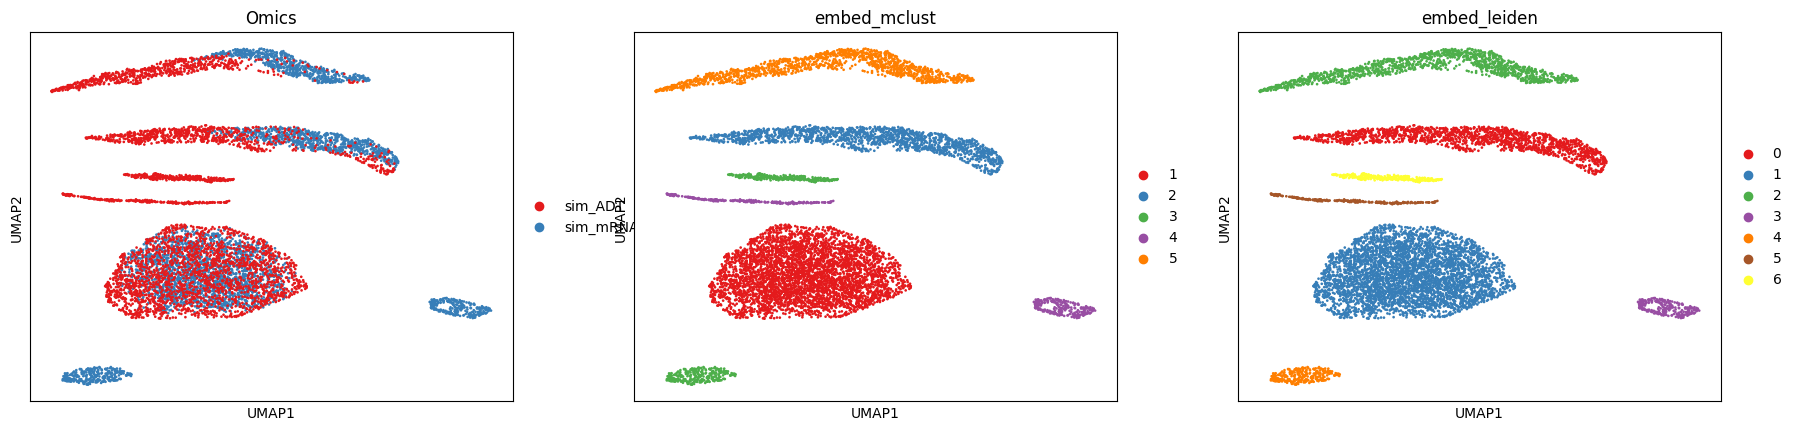

Best resolution:  0.03
fitting ...
  |======================================================================| 100%


[<Axes: title={'center': 'Ground_truth'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'Leiden'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'Mclust'}, xlabel='spatial1', ylabel='spatial2'>]

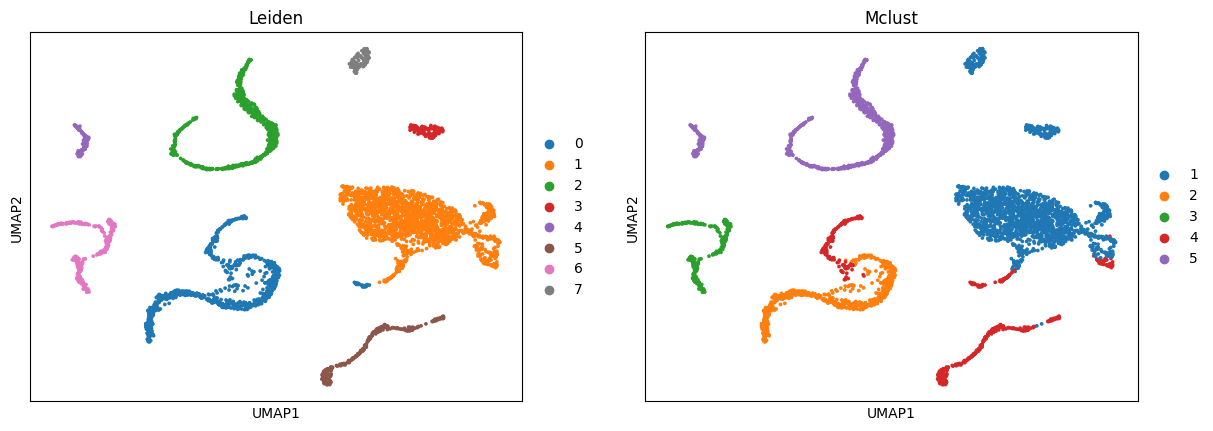

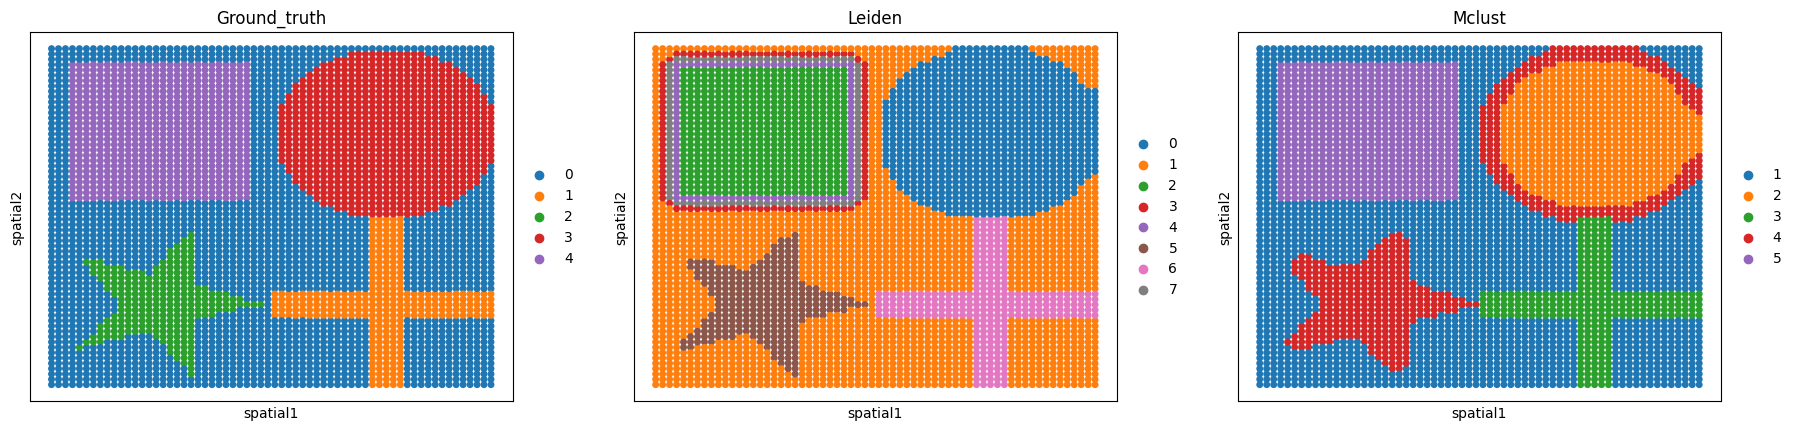

In [1]:
######## 尝试一下DIRAC
import os
import random

import pandas as pd
import numpy as np
import torch
import scanpy as sc
import matplotlib.pyplot as plt
import anndata

import sys
sys.path.append("/home/project/11003054/changxu/Projects/DIRAC/DIRAC")
import diracv3 as sd

def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch(seed=0)

data_path = "/home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics/sim1"
data_name = "sim"
methods = "DIRAC"
out_path = "/home/project/11003054/changxu/Projects/DIRAC/Section-2"

adata_RNA = sc.read(os.path.join(data_path, f"{data_name}_RNA.h5ad"))
adata_Protein = sc.read(os.path.join(data_path, f"{data_name}_ADT.h5ad"))

######### Define colors for spatial multi-omics domain
colormaps= ["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#A65628", "#FFFF33", "#F781BF", "#999999",
            "#E5D8BD", "#B3CDE3", "#CCEBC5", "#FED9A6", "#FBB4AE", "#8DD3C7", "#BEBADA", "#80B1D3", "#B3DE69", "#FCCDE5",
            "#BC80BD", "#FFED6F", "#8DA0CB", "#E78AC3", "#E5C494", "#CCCCCC", "#FB9A99", "#E31A1C", "#CAB2D6","#6A3D9A", "#B15928"]

######### Data processing
adata_RNA.obs["Omics"] = data_name + "_mRNA"
adata_RNA.obs['Omics'] = adata_RNA.obs['Omics'].astype('category')
adata_Protein.obs["Omics"] = data_name + "_ADT"
adata_Protein.obs['Omics'] = adata_Protein.obs['Omics'].astype('category')


######### Data processing
sc.pp.filter_genes(adata_RNA, min_cells=3)
sc.pp.normalize_total(adata_RNA)
sc.pp.log1p(adata_RNA)
sc.pp.scale(adata_RNA)
sc.tl.pca(adata_RNA, n_comps=50)


sc.pp.normalize_total(adata_Protein)
sc.pp.log1p(adata_Protein)
sc.pp.scale(adata_Protein)


edge_index = sd.utils.get_single_edge_index(adata_RNA.obsm["spatial"], n_neighbors = 8)
print(len(edge_index)/adata_RNA.shape[0])
edge_index = torch.LongTensor(edge_index).T


y = pd.Categorical(
    np.array(adata_RNA.obs["Omics"]),
    categories=np.unique(adata_RNA.obs["Omics"]),
    ).codes
save_path = os.path.join(out_path, "Results", f"{data_name}_{methods}")
if not os.path.exists(save_path):
    os.makedirs(save_path)


###### Training Dirac for spatial multi-omics
dirac = sd.main.integrate_app(save_path = save_path, 
                              use_gpu = True, 
                              subgraph = False)
samples = dirac._get_data(dataset_list = [adata_RNA.obsm['X_pca'].copy(), adata_Protein.X.copy()],
                        batch_list = [y, y],
                        domain_list = [np.zeros(adata_RNA.shape[0]), np.ones(adata_Protein.shape[0])],
                        edge_index = edge_index,
                         )
models = dirac._get_model(samples,
                        n_hiddens = 128,
                        n_outputs = 64,
                        opt_GNN = "GAT",)
data_z, combine_recon, now = dirac._train_dirac_integrate(samples = samples,
                                            models = models,
                                            epochs = 300,
                                            lamb = 5e-4,
                                            scale_loss = 0.025,
                                            lr = 1e-3,
                                            wd = 5e-2)


adata_RNA.obsm[f"{methods}_embed"] = data_z[: adata_RNA.shape[0], :]
adata_Protein.obsm[f"{methods}_embed"] = data_z[adata_RNA.shape[0] :, :]
adata_RNA.obsm["combine_recon"] = combine_recon
adata_Protein.obsm["combine_recon"] = combine_recon

n_clusters = 5
adata = anndata.AnnData(data_z)
adata.obs = pd.concat([adata_RNA.obs, adata_Protein.obs])
adata.obsm[f"{methods}_embed"] = data_z
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
res_RNA_ATAC = sd.utils._priori_cluster(adata, eval_cluster_n = n_clusters)
sc.tl.leiden(adata, resolution = res_RNA_ATAC, key_added="embed_leiden", flavor="igraph", n_iterations=2, directed=False)
sd.utils.mclust_R(adata=adata, num_cluster = n_clusters, used_obsm=f"{methods}_embed", key_added="embed_mclust")
sc.pl.umap(adata, color=['Omics', "embed_mclust", "embed_leiden"], palette = colormaps)
# plt.savefig(os.path.join(save_path, f"{data_name}_{methods}_embed_umap_{now}.pdf"), bbox_inches='tight', dpi = 300)

sc.pp.neighbors(adata_RNA, use_rep='combine_recon', n_neighbors=30)
res_RNA_ATAC = sd.utils._priori_cluster(adata_RNA, eval_cluster_n = n_clusters)
sc.tl.leiden(adata_RNA, resolution = res_RNA_ATAC, key_added="Combined_leiden", flavor="igraph", n_iterations=2, directed=False)
sd.utils.mclust_R(adata=adata_RNA, num_cluster = n_clusters, used_obsm="combine_recon",key_added="Combined_mclust")

sc.tl.umap(adata_RNA)

sc.pl.umap(adata_RNA, color=["Combined_leiden",'Combined_mclust'],title=['Leiden','Mclust'], show=False)
sc.pl.embedding(adata_RNA, basis='spatial', color=["ground_truth", "Combined_leiden",'Combined_mclust'], title=['Ground_truth','Leiden','Mclust'], s=100, show=False)

Saved dataset 1 to /home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics/sim_1
Saved dataset 2 to /home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics/sim_2
Saved dataset 3 to /home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics/sim_3
Saved dataset 4 to /home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics/sim_4
Saved dataset 5 to /home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics/sim_5
Saved dataset 6 to /home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics/sim_6
Saved dataset 7 to /home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics/sim_7
Saved dataset 8 to /home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics/sim_8
Saved dataset 9 to /home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics/sim_9
Saved dataset 10 to /home/pr

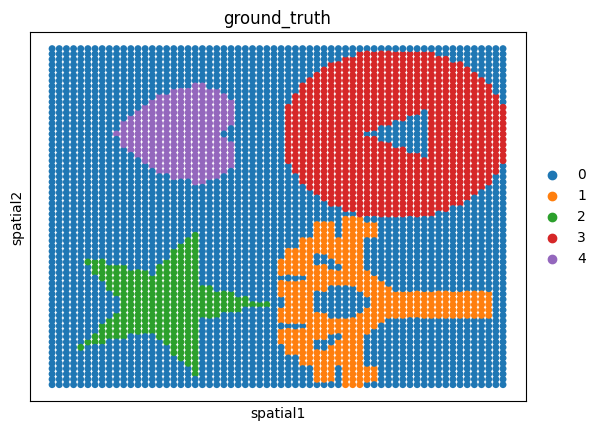

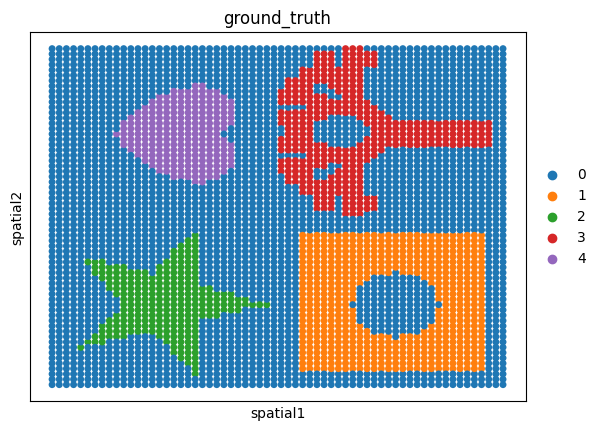

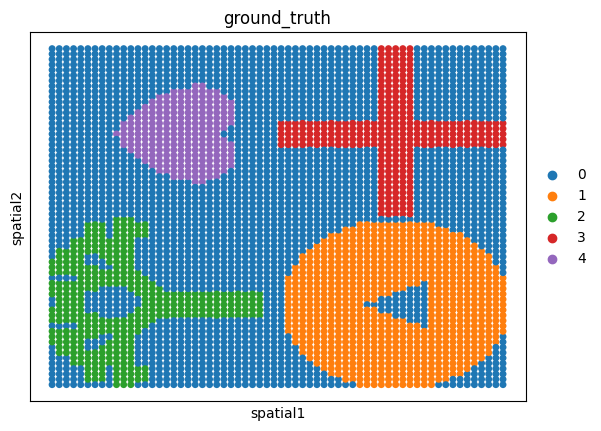

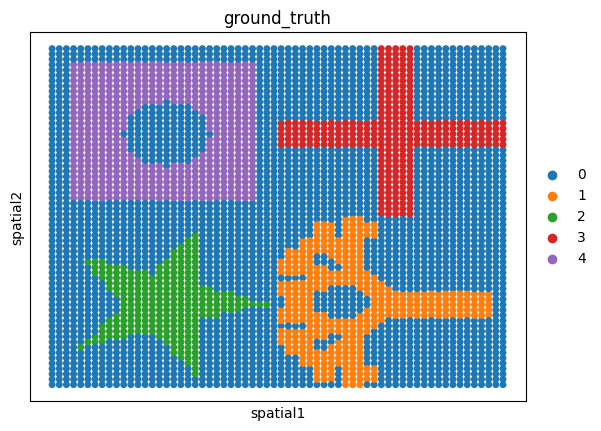

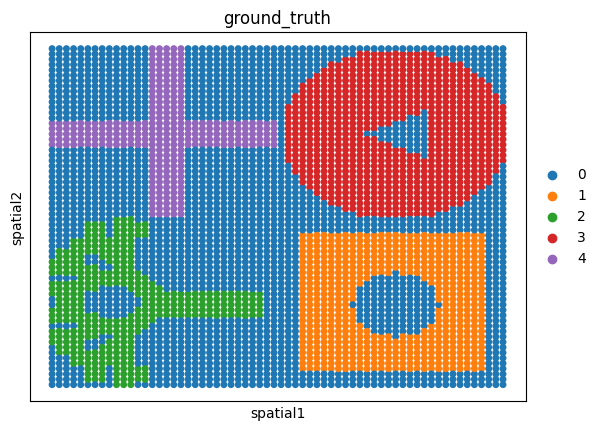

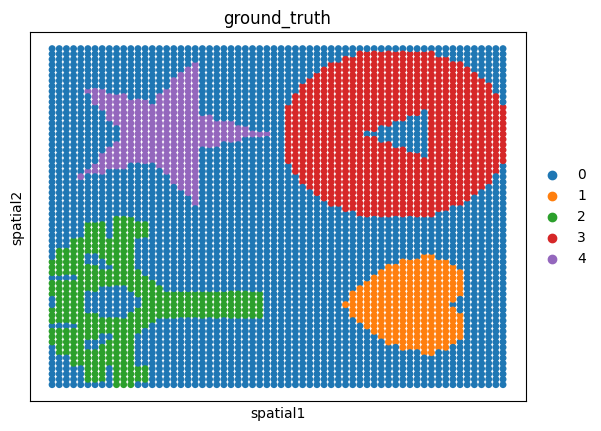

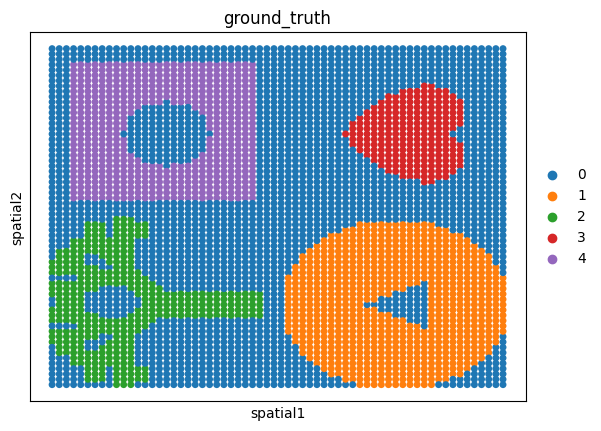

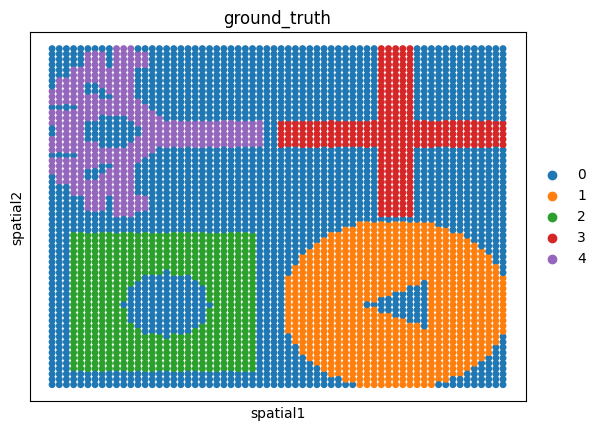

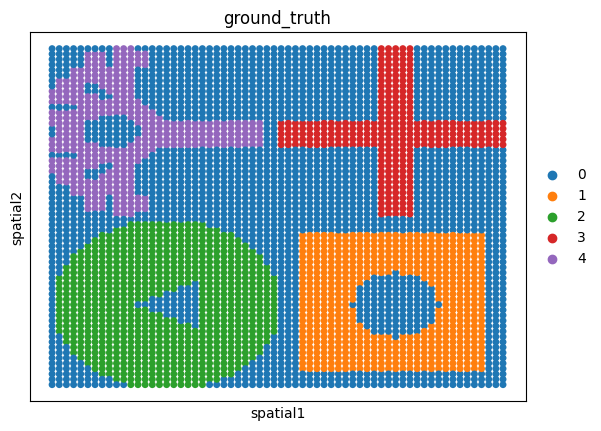

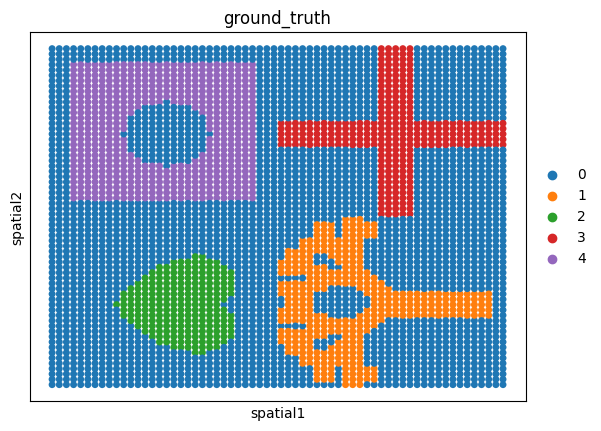

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Enhanced spatial simulation with multi-omics data generation
"""
import random
import os
import numpy as np
from pandas import get_dummies
from anndata import AnnData
from scipy.stats import norm, poisson
from pathlib import Path
dtp = "float32"
random.seed(101)
import scanpy as sc
import sys
sys.path.append("/home/project/11003054/changxu/Projects/DIRAC/Section-2/nsf-paper-main")
from utils import misc, preprocess

# Enhanced pattern generation functions
def squares(size=12):
    """Generate square patterns of given size"""
    A = np.zeros([size,size])
    quarter = size//4
    A[quarter:3*quarter, quarter:3*quarter] = 1
    return A

def circles(size=12):
    """Generate circle patterns of given size"""
    A = np.zeros((size, size))
    center = size//2
    radius = size//3
    for i in range(size):
        for j in range(size):
            if (i - center)**2 + (j - center)**2 < radius**2:
                A[i, j] = 1
    return A

def triangles(size=12):
    """Generate triangle patterns of given size"""
    A = np.zeros((size, size))
    for i in range(size):
        A[i, :i+1] = 1
    return A

def stripes(size=12, orientation='horizontal'):
    """Generate stripe patterns"""
    A = np.zeros((size, size))
    if orientation == 'horizontal':
        for i in range(0, size, 2):
            A[i, :] = 1
    else:  # vertical
        for j in range(0, size, 2):
            A[:, j] = 1
    return A

def checkerboards(size=12):
    """Generate checkerboard patterns"""
    A = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if (i + j) % 2 == 0:
                A[i, j] = 1
    return A

def crosses(size=12):
    """Generate cross patterns"""
    A = np.zeros((size, size))
    center = size//2
    thickness = max(1, size//6)
    A[center-thickness:center+thickness, :] = 1
    A[:, center-thickness:center+thickness] = 1
    return A


def ggblocks(nside=64, block_size = 32):
    """
    Generate large blocky spatial patterns where each pattern is a separate class.
    Includes a five-pointed star pattern.
    - Each pattern occupies a distinct block in the spatial grid
    - block_size must divide nside
    - Returns: (num_patterns, nside*nside) array where each row is one pattern
    """
    if nside % block_size != 0:
        raise ValueError("nside must be divisible by block_size")

    n_blocks = nside // block_size
    num_patterns = min(4, n_blocks**2)  # We'll generate up to 4 distinct patterns

    # Define pattern generators (expanded to 12 patterns)
    # def square_pattern(size):
    #     A = np.zeros((size, size))
    #     q = size // 10
    #     A[q:-q, q:-q] = 1
    #     return A

    def square_pattern(size):
        A = np.zeros((size, size))
        q = size // 10
        A[q:-q, q:-q] = 1 
        center = size // 2
        radius = size // 5
        Y, X = np.ogrid[:size, :size]
        mask = (X - center)**2 + (Y - center)**2 <= radius**2
        A[mask] = 0

        return A

    def cross_pattern(size, thickness=5):
        A = np.zeros((size, size))
        c = size // 2
        half_thickness = thickness // 2
        start = c - half_thickness
        end = c + half_thickness + (thickness % 2)
        start = max(0, start)
        end = min(size, end)
        A[:, start:end] = 1
        A[start:end, :] = 1
        return A

    def diag_pattern(size):
        A = np.eye(size)
        A += np.fliplr(np.eye(size))
        return (A > 0).astype(float)

    # def circle_pattern(size):
    #     A = np.zeros((size, size))
    #     r = size // 2
    #     cx, cy = size // 2, size // 2
    #     for i in range(size):
    #         for j in range(size):
    #             if (i - cx) ** 2 + (j - cy) ** 2 < r ** 2:
    #                 A[i, j] = 1
    #     return A

    def circle_pattern(size):
        A = np.zeros((size, size))
        r = size // 2
        cx, cy = size // 2, size // 2

        for i in range(size):
            for j in range(size):
                if (i - cx) ** 2 + (j - cy) ** 2 < r ** 2:
                    A[i, j] = 1

        h = size // 3  
        x1, y1 = cx, cy - h // 2
        x2, y2 = cx - h // 2, cy + h // 2
        x3, y3 = cx + h // 2, cy + h // 2

        def is_inside_triangle(px, py):
            def sign(xa, ya, xb, yb, xc, yc):
                return (xa - xc) * (yb - yc) - (xb - xc) * (ya - yc)
            b1 = sign(px, py, x1, y1, x2, y2) < 0
            b2 = sign(px, py, x2, y2, x3, y3) < 0
            b3 = sign(px, py, x3, y3, x1, y1) < 0
            return b1 == b2 == b3

        for i in range(size):
            for j in range(size):
                if A[i, j] == 1 and is_inside_triangle(i, j):
                    A[i, j] = 0
        return A

    def star_pattern(size):
        A = np.zeros((size, size))
        center = size // 2
        radius = size // 2 - 2
        angles = np.linspace(0, 2*np.pi, 6)[:-1]
        star_points = []
        for i, angle in enumerate(angles):
            x = center + radius * np.cos(angle)
            y = center + radius * np.sin(angle)
            star_points.append((x, y))
            inner_angle = angle + 2*np.pi/10
            x = center + (radius/2.5) * np.cos(inner_angle)
            y = center + (radius/2.5) * np.sin(inner_angle)
            star_points.append((x, y))
        star_points = np.array(star_points).astype(int)
        from matplotlib.path import Path
        x, y = np.meshgrid(np.arange(size), np.arange(size))
        points = np.vstack((x.flatten(), y.flatten())).T
        path = Path(star_points)
        mask = path.contains_points(points)
        A = mask.reshape(size, size).astype(float)
        return A

    def spiral_pattern(size):
        A = np.zeros((size, size))
        center = size // 2
        for i in range(size):
            for j in range(size):
                r = np.sqrt((i - center)**2 + (j - center)**2)
                theta = np.arctan2(j - center, i - center)
                if r < center and np.sin(5 * theta + r) > 0.5:
                    A[i, j] = 1
        return A

    def heart_pattern(size):
        A = np.zeros((size, size))
        center = size // 2
        scale = size / 4
        for i in range(size):
            for j in range(size):
                x = (i - center) / scale
                y = (j - center) / scale
                if (x**2 + y**2 - 1)**3 - x**2 * y**3 < 0:
                    A[i, j] = 1
        return A

    def maze_pattern(size):
        A = np.zeros((size, size))
        for i in range(size):
            for j in range(size):
                if (i % 4 == 0) or (j % 4 == 0 and (i // 4 + j // 4) % 2 == 0):
                    A[i, j] = 1
        return A

    def concentric_circles(size):
        A = np.zeros((size, size))
        center = size // 2
        for i in range(size):
            for j in range(size):
                r = np.sqrt((i - center)**2 + (j - center)**2)
                if r % 5 < 2.5:
                    A[i, j] = 1
        return A

    def checkerboard_large(size):
        A = np.zeros((size, size))
        for i in range(size):
            for j in range(size):
                if (i // 3 + j // 3) % 2 == 0:
                    A[i, j] = 1
        return A

    def stripes_diagonal(size):
        A = np.zeros((size, size))
        for i in range(size):
            for j in range(size):
                if (i + j) % 4 < 2:
                    A[i, j] = 1
        return A

    def dots_pattern(size):
        A = np.zeros((size, size))
        for i in range(2, size, 5):
            for j in range(2, size, 5):
                A[i, j] = 1
        return A
        
    def crescent_moon(size):
        A = np.zeros((size, size))
        center = size // 2
        outer_r = size // 2 - 2
        inner_r = outer_r - size // 5
        for i in range(size):
            for j in range(size):
                d = np.sqrt((i-center)**2 + (j-center)**2)
                angle = np.arctan2(j-center, i-center)
                if d < outer_r and not (d < inner_r and angle > -np.pi/2 and angle < np.pi/2):
                    A[i,j] = 1
        return A

    def fibonacci_spiral(size):
        A = np.zeros((size, size))
        center = size // 2
        scale = size / 3    
        phi = (1 + np.sqrt(5)) / 2  
        golden_angle = 2 * np.pi * (2 - phi)  
        n_points = 100 
        angles = golden_angle * np.arange(n_points)  
        radii = scale * np.sqrt(np.arange(n_points) / np.sqrt(n_points)) 
        points = np.array([
            center + radii * np.cos(angles),
            center + radii * np.sin(angles)
        ]).T.astype(int)

        for i in range(len(points)-1):
            x1, y1 = points[i]
            x2, y2 = points[i+1]
            steps = max(abs(x2-x1), abs(y2-y1)) + 1
            for t in np.linspace(0, 1, steps):
                x = int(round(x1 + t*(x2-x1)))
                y = int(round(y1 + t*(y2-y1)))
                if 0 <= x < size and 0 <= y < size:
                    A[x, y] = 1      
        return A

    def cellular_automata(size, rule=30, random_init=True):
        A = np.zeros((size, size), dtype=int)

        if random_init:
            A[0, :] = np.random.randint(0, 2, size)
        else:
            A[0, size//2] = 1  

        rule_bits = np.array([int(b) for b in f"{rule:08b}"[::-1]])
    
        for i in range(1, size):
            for j in range(size):
                left = A[i-1, (j-1)%size]
                center = A[i-1, j]
                right = A[i-1, (j+1)%size]
                neighborhood = (left << 2) | (center << 1) | right
                A[i, j] = rule_bits[neighborhood]
    
        return A

    def fractal_tree(size):
        A = np.zeros((size, size))
        start_x, start_y = size//2, size-5
        branch_length = size // 3
        
        def draw_branch(x, y, length, angle, thickness):
            if length < 2:
                return
            end_x = x - length * np.sin(angle)
            end_y = y - length * np.cos(angle)
            steps = max(abs(int(end_x-x)), abs(int(end_y-y))) + 1
            for t in np.linspace(0, 1, steps):
                tx = x + t*(end_x-x)
                ty = y + t*(end_y-y)
                for dx in range(-thickness, thickness+1):
                    for dy in range(-thickness, thickness+1):
                        nx, ny = int(tx+dx), int(ty+dy)
                        if 0 <= nx < size and 0 <= ny < size:
                            A[nx, ny] = 1
            new_length = length * 0.7
            new_thickness = max(1, thickness-1)
            draw_branch(end_x, end_y, new_length, angle-np.pi/5, new_thickness)
            draw_branch(end_x, end_y, new_length, angle+np.pi/5, new_thickness)
        
        draw_branch(start_x, start_y, branch_length, 0, 2)
        return A

    # All available patterns
    all_patterns = [
        square_pattern, 
        circle_pattern, 
        star_pattern, 
        cross_pattern,
        # spiral_pattern,
        heart_pattern,
        # maze_pattern,
        # diag_pattern,
        # concentric_circles,
        # checkerboard_large,
        # stripes_diagonal,
        # dots_pattern,
        # crescent_moon,      
        # fibonacci_spiral,   
        # cellular_automata,  
        fractal_tree,        
    ]
    
    # Randomly select 4 unique patterns
    selected_patterns = random.sample(all_patterns, 4)
    
    # Initialize output array (num_patterns, nside*nside)
    output = np.zeros((num_patterns, nside*nside))

    for pattern_idx in range(num_patterns):
        # Create empty grid for this pattern
        grid = np.zeros((nside, nside))
        
        # Calculate block position for this pattern
        row = pattern_idx // n_blocks
        col = pattern_idx % n_blocks
        
        # Only place this pattern in its designated block
        if row < n_blocks and col < n_blocks:
            start_x = row * block_size
            start_y = col * block_size
            block_pattern = selected_patterns[pattern_idx % len(selected_patterns)](block_size)
            grid[start_x:start_x+block_size, start_y:start_y+block_size] = block_pattern
        
        # Store this pattern's grid
        output[pattern_idx, :] = grid.flatten()

    return output


def quilt(size=12):
    """Original quilt patterns"""
    patterns = [
        squares(size),
        crosses(size),
        circles(size),
        triangles(size)
    ]
    L = len(patterns)
    pattern_size = patterns[0].size
    A = np.zeros([L, pattern_size])
    for i, pattern in enumerate(patterns):
        A[i, :] = pattern.flatten()
    return A

def sqrt_int(x):
    z = int(round(x**.5))
    if x == z**2:
        return z
    else:
        raise ValueError("x must be a square integer")

def gen_spatial_factors(scenario="quilt", nside=36):
    """
    Generate spatial factors for different scenarios
    """
    if scenario == "quilt":
        A = quilt()
    elif scenario == "ggblocks":
        A = ggblocks(nside)
    elif scenario == "both":
        A1 = quilt()
        A2 = ggblocks(nside)
        A = np.vstack((A1, A2))
    else:
        raise ValueError("scenario must be 'quilt', 'ggblocks' or 'both'")
    
    unit = sqrt_int(A.shape[1])
    assert nside % unit == 0
    ncopy = nside // unit
    N = nside**2
    L = A.shape[0]
    A = A.reshape((L, unit, unit))
    A = np.kron(A, np.ones((1, ncopy, ncopy)))
    F = A.reshape((L, N)).T
    return F

def gen_spatial_coords(N):
    """Generate spatial coordinates"""
    X = misc.make_grid(N)
    X[:, 1] = -X[:, 1]  # make the display the same
    return preprocess.rescale_spatial_coords(X)

def gen_nonspatial_factors(N, L=3, nzprob=0.2, seed=101):
    """Generate non-spatial factors"""
    rng = np.random.default_rng(seed)
    return rng.binomial(1, nzprob, size=(N, L))

def gen_loadings(Lsp, Lns=3, Jsp=0, Jmix=500, Jns=0, 
                 expr_mean=20.0, mix_frac_spat=0.1, 
                 modality='RNA', seed=101):
    """
    Generate loadings matrix for different modalities
    """
    rng = np.random.default_rng(seed)
    J = Jsp + Jmix + Jns
    
    # Adjust parameters based on modality
    if modality == 'ADT':
        mix_frac_spat = 0.2  # ADT often more spatially structured
    elif modality == 'ATAC':
        mix_frac_spat = 0.1  # Chromatin accessibility may be less spatially structured
    
    if Lsp > 0:
        w = rng.choice(Lsp, J, replace=True)
        W = get_dummies(w).to_numpy(dtype=dtp)
    else:
        W = np.zeros((J, 0))
    
    if Lns > 0:
        v = rng.choice(Lns, J, replace=True)
        V = get_dummies(v).to_numpy(dtype=dtp)
    else:
        V = np.zeros((J, 0))
    
    # Pure spatial features
    W[:Jsp, :] *= expr_mean
    V[:Jsp, :] = 0
    
    # Mixed features
    W[Jsp:(Jsp+Jmix), :] *= (mix_frac_spat * expr_mean)
    V[Jsp:(Jsp+Jmix), :] *= ((1 - mix_frac_spat) * expr_mean)
    
    # Pure non-spatial features
    W[(Jsp+Jmix):, :] = 0
    V[(Jsp+Jmix):, :] *= expr_mean
    
    return W, V

def add_gaussian_noise(data, snr=20, seed=101):
    """Add Gaussian noise to data with specified signal-to-noise ratio"""
    rng = np.random.default_rng(seed)
    signal_power = np.mean(data**2)
    noise_power = signal_power / snr
    noise = rng.normal(0, np.sqrt(noise_power), data.shape)
    return data + noise

def sim_multiomics(scenario, nside=36, nzprob_nsp=0.2, bkg_mean=0.02, 
                  nb_shape=10.0, seed=101, **kwargs):
    """
    Simulate multi-omics spatial data (RNA, ADT, ATAC)
    """
    # Generate common spatial structure
    if scenario == "both":
        F1 = gen_spatial_factors(nside=nside, scenario="ggblocks")
        F2 = gen_spatial_factors(nside=nside, scenario="quilt")
        F = np.hstack((F1, F2))
    else:
        F = gen_spatial_factors(scenario=scenario, nside=nside)
    
    rng = np.random.default_rng(seed)
    N = nside**2
    X = gen_spatial_coords(N)
    U = gen_nonspatial_factors(N, L=3, nzprob=nzprob_nsp, seed=seed)
    
    # Initialize empty AnnData object with correct number of observations
    adata = AnnData(X=np.empty((N, 0)))  # Initialize with N obs and 0 vars
    
    # Add spatial coordinates and factors
    adata.obsm["spatial"] = X
    adata.obsm["spfac"] = F
    adata.obsm["nsfac"] = U
    
    # Simulate each modality
    modalities = {
        'RNA': {'Jsp': 200, 'Jmix': 1600, 'Jns': 200, 'expr_mean': 20},
        'ADT': {'Jsp': 10, 'Jmix': 80, 'Jns': 10, 'expr_mean': 100},
        'ATAC': {'Jsp': 500, 'Jmix': 3000, 'Jns': 500, 'expr_mean': 10}
    }
    
    for modality, params in modalities.items():
        # Update params with any modality-specific kwargs
        mod_params = params.copy()
        mod_params.update(kwargs.get(modality, {}))
        
        # Generate loadings for this modality
        modality_seed = seed + abs(hash(modality)) % (2**32)
        W, V = gen_loadings(F.shape[1], Lns=U.shape[1], 
                    modality=modality, seed=modality_seed, 
                    **mod_params)
        
        # Simulate counts
        Lambda = bkg_mean + F @ W.T + U @ V.T
        r = nb_shape
        
        # Different count models for different modalities
        if modality == 'ATAC':
            counts = rng.poisson(Lambda)
            counts = add_gaussian_noise(counts, seed = modality_seed)
            zero_mask = rng.random(Lambda.shape) < 0.5  # 50% additional zeros
            counts[zero_mask] = 0
        elif modality == 'RNA':
            counts = rng.negative_binomial(Lambda, r/(Lambda+r))
            counts = add_gaussian_noise(counts, seed = modality_seed)
            zero_mask = rng.random(Lambda.shape) < 0.3  # 30% additional zeros
            counts[zero_mask] = 0
        elif modality == 'ADT':
            counts = rng.poisson(Lambda)
            counts = add_gaussian_noise(counts, seed = modality_seed)
            zero_mask = rng.random(Lambda.shape) < 0.1  # 10% additional zeros
            counts[zero_mask] = 0
        else:
            counts = rng.negative_binomial(r, r/(Lambda+r))
            counts = add_gaussian_noise(counts, seed = modality_seed)
        
        counts = np.clip(counts, 0, None).astype(int)
        
        # Store in AnnData layers
        adata.obsm[f"counts_{modality}"] = counts
        adata.uns[f"loadings_{modality}"] = np.hstack((W, V))
    
    # Shuffle indices
    idx = list(range(adata.shape[0]))
    random.shuffle(idx)
    adata = adata[idx, :].copy()
    
    return adata

def sim2anndata(locs, outcome, spfac, spload, nsfac=None, nsload=None):
    """
    Compatibility function to match original function signature
    """
    obsm = {"spatial": locs, "spfac": spfac, "nsfac": nsfac}
    varm = {"spload": spload, "nsload": nsload}
    ad = AnnData(outcome, obsm=obsm, varm=varm)
    ad.layers = {"counts": ad.X.copy()}
    idx = list(range(ad.shape[0]))
    random.shuffle(idx)
    ad = ad[idx, :]
    return ad

def sim(scenario, nside=36, nzprob_nsp=0.2, bkg_mean=0.02, 
       nb_shape=10.0, seed=101, multiomics=False, **kwargs):
    """
    Main simulation function that can handle both single and multi-omics
    """
    if multiomics:
        return sim_multiomics(scenario, nside=nside, nzprob_nsp=nzprob_nsp,
                            bkg_mean=bkg_mean, nb_shape=nb_shape,
                            seed=seed, **kwargs)
    else:
        # Original single-modality simulation
        if scenario == "both":
            F1 = gen_spatial_factors(nside=nside, scenario="ggblocks")
            F2 = gen_spatial_factors(nside=nside, scenario="quilt")
            F = np.hstack((F1, F2))
        else:
            F = gen_spatial_factors(scenario=scenario, nside=nside)
        
        rng = np.random.default_rng(seed)
        N = nside**2
        X = gen_spatial_coords(N)
        W, V = gen_loadings(F.shape[1], seed=seed, **kwargs)
        U = gen_nonspatial_factors(N, L=V.shape[1], nzprob=nzprob_nsp, seed=seed)
        Lambda = bkg_mean + F @ W.T + U @ V.T
        r = nb_shape
        Y = rng.negative_binomial(r, r/(Lambda+r))
        Y = add_gaussian_noise(Y, snr=20, seed=seed)
        Y = np.clip(Y, 0, None).astype(int)
        
        return sim2anndata(X, Y, F, W, nsfac=U, nsload=V)

def assign_unique_labels(matrix):
    row_strs = ['_'.join(map(str, row)) for row in matrix]
    unique_rows, labels = np.unique(row_strs, return_inverse=True)
    return labels

def save_datasets(
    output_dir = "simulated_datasets",
    nside = 64,
    seed = 1,
    num_datasets = 10
):
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    for i in range(num_datasets):
        # Create subdirectory for this dataset
        dataset_dir = os.path.join(output_dir, f"sim_{i+1}")
        Path(dataset_dir).mkdir(parents=True, exist_ok=True)
        
        # Generate dataset with random seed
        current_seed = seed + i
        adata = sim("ggblocks", multiomics=True, nside=nside, seed=current_seed)
        labels_S1 = assign_unique_labels(adata.obsm['spfac'])
        adata.obs['ground_truth'] = labels_S1
        adata.obs['ground_truth'] = adata.obs['ground_truth'].astype('category')

        adata_RNA = AnnData(X=adata.obsm['counts_RNA'], obs=adata.obs)
        adata_RNA.obsm['spatial'] = adata.obsm['spatial']    

        adata_ADT = AnnData(X=adata.obsm['counts_ADT'], obs=adata.obs)
        adata_ADT.obsm['spatial'] = adata.obsm['spatial']
            
        adata_ATAC = AnnData(X=adata.obsm['counts_ATAC'], obs=adata.obs)
        adata_ATAC.obsm['spatial'] = adata.obsm['spatial']
                
        # Save each modality
        adata_RNA.write(os.path.join(dataset_dir, "sim_RNA.h5ad"))
        adata_ATAC.write(os.path.join(dataset_dir, "sim_ATAC.h5ad"))
        adata_ADT.write(os.path.join(dataset_dir, "sim_ADT.h5ad"))
        
        print(f"Saved dataset {i+1} to {dataset_dir}")

def plot_figure(ad, res=0.1):
    sc.pp.filter_genes(ad, min_cells=3)
    sc.pp.normalize_total(ad)
    sc.pp.log1p(ad)
    sc.pp.scale(ad)
    sc.tl.pca(ad, n_comps=50)
    sc.pp.neighbors(ad)
    sc.tl.umap(ad)
    sc.tl.leiden(ad, resolution = res, key_added="Cluster")
    sc.pl.umap(ad, color=["Cluster"])
    sc.pl.embedding(ad, basis='spatial', color=['ground_truth',"Cluster"], s=100)

# Generate and save 10 datasets with different random patterns
num_datasets = 10
save_datasets(output_dir="/home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics", 
             nside=64, seed=101, num_datasets=num_datasets)

import os
out_path = "/home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics"
for i in range(num_datasets):
    ad = sc.read(os.path.join(out_path,f"sim_{i+1}","sim_RNA.h5ad"))
    sc.pl.embedding(ad, basis='spatial', color=['ground_truth'], s=100)

8.0
Found 2 unique domains.


Project..: 100%|█| 200/200 [00:16<00


Best resolution:  0.09000000000000001


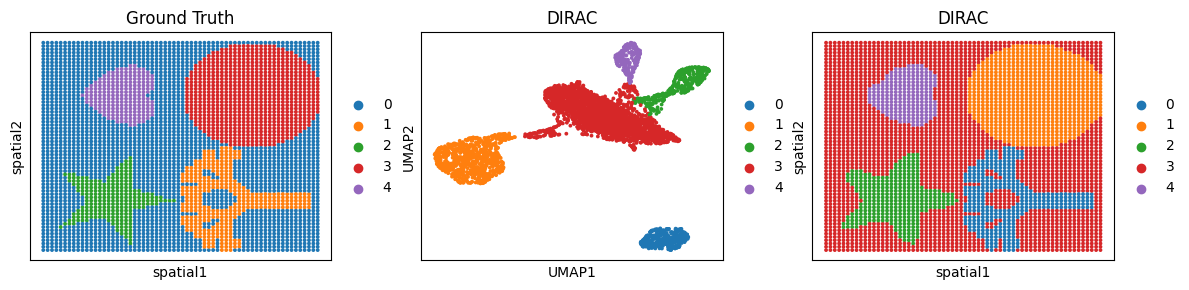

8.0
Found 2 unique domains.


Project..: 100%|█| 200/200 [00:16<00


Best resolution:  0.11000000000000001


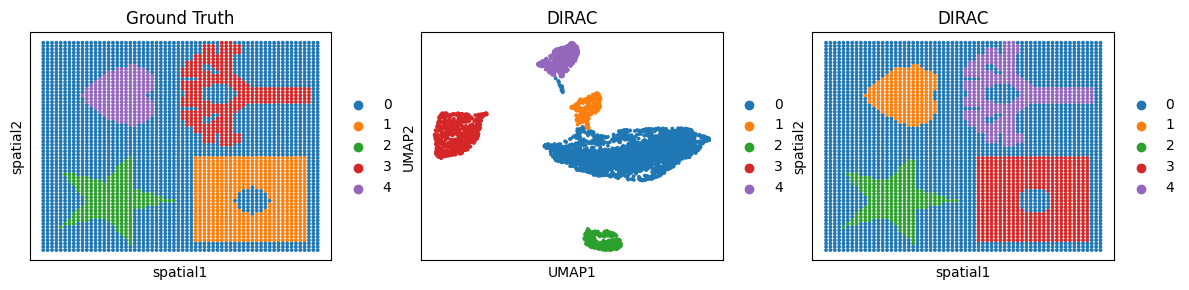

8.0
Found 2 unique domains.


Project..: 100%|█| 200/200 [00:16<00


Best resolution:  0.03


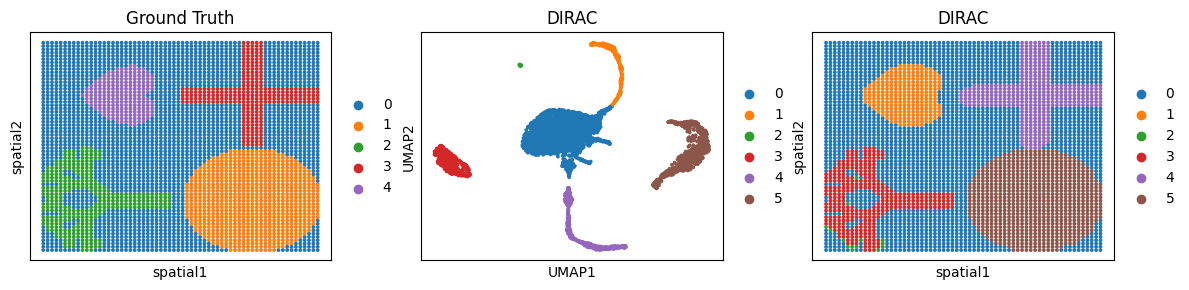

8.0
Found 2 unique domains.


Project..: 100%|█| 200/200 [00:16<00


Best resolution:  0.08000000000000002


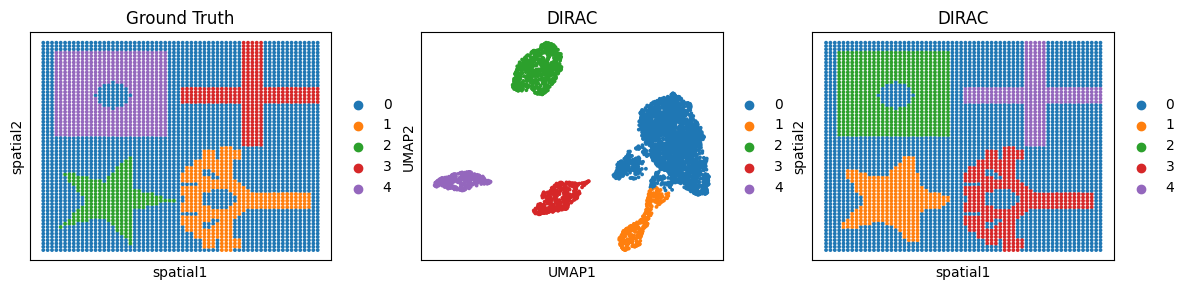

8.0
Found 2 unique domains.


Project..: 100%|█| 200/200 [00:16<00


Best resolution:  0.05


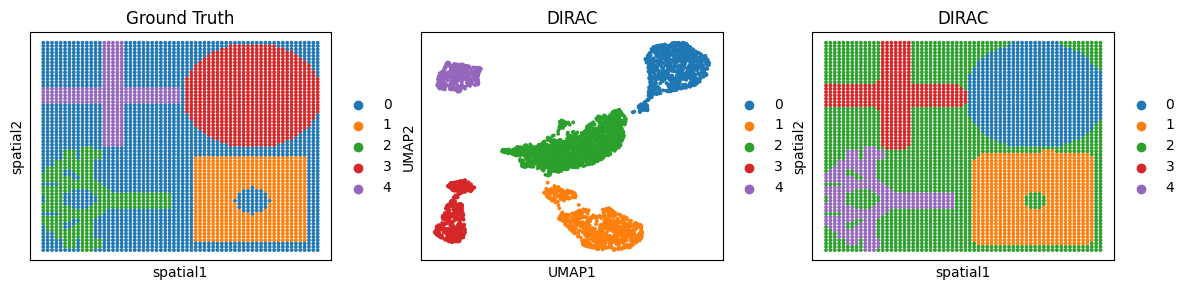

8.0
Found 2 unique domains.


Project..: 100%|█| 200/200 [00:16<00


Best resolution:  0.04


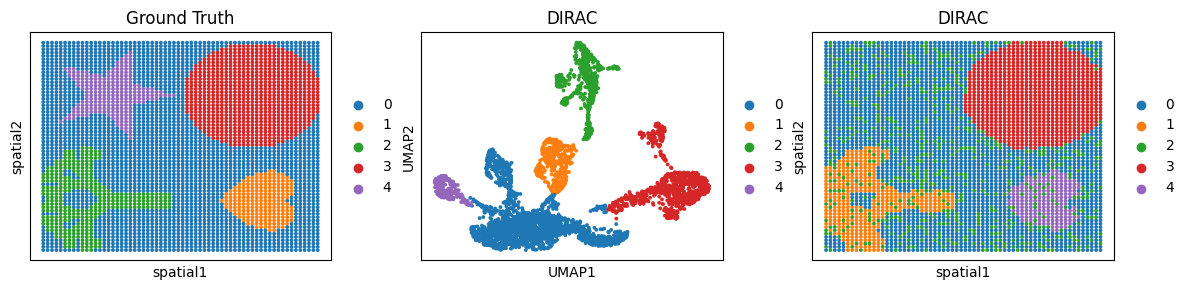

8.0
Found 2 unique domains.


Project..: 100%|█| 200/200 [00:16<00


Best resolution:  0.1


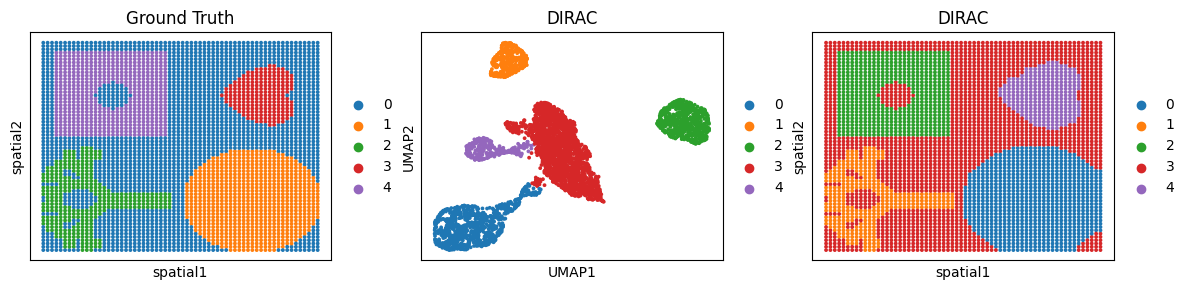

8.0
Found 2 unique domains.


Project..: 100%|█| 200/200 [00:24<00


Best resolution:  0.05


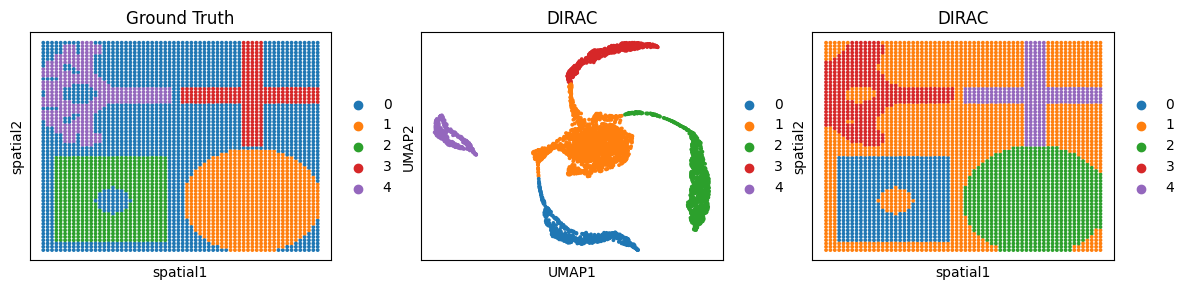

8.0
Found 2 unique domains.


Project..: 100%|█| 200/200 [00:26<00


Best resolution:  0.1


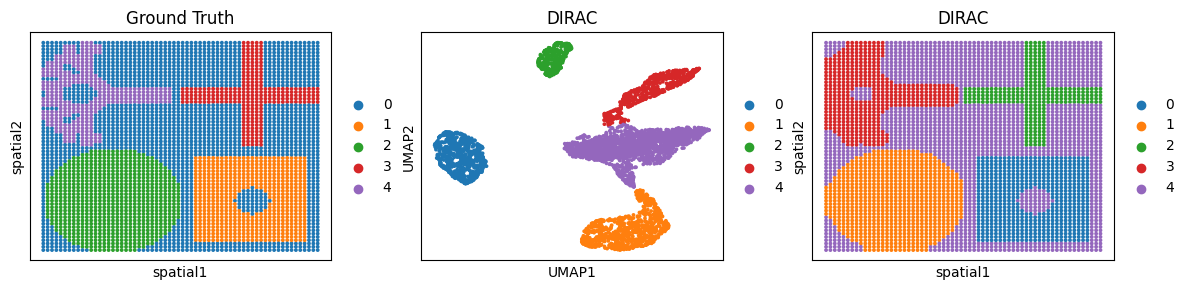

8.0
Found 2 unique domains.


Project..: 100%|█| 200/200 [00:26<00


Best resolution:  0.03


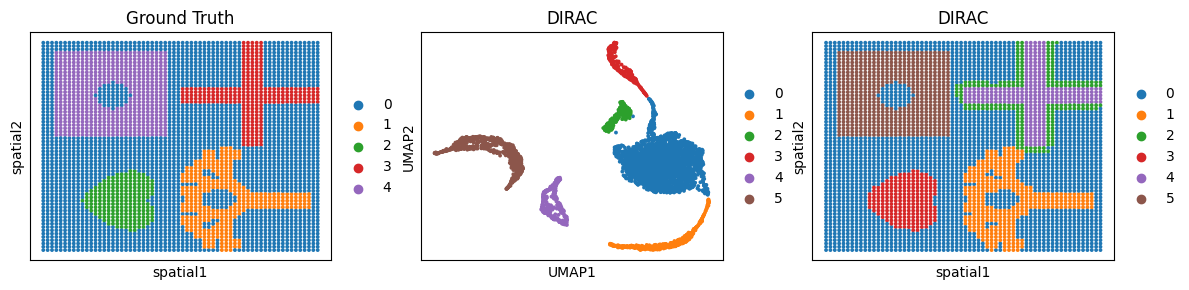

In [1]:
import os
import random

import pandas as pd
import numpy as np
import torch
import scanpy as sc
import matplotlib.pyplot as plt
import anndata

import sys
sys.path.append("/home/project/11003054/changxu/Projects/DIRAC/DIRAC")
import diracv3 as sd

def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch(seed=0)


for i in range(10):
    data_path = f"/home/project/11003054/changxu/Projects/DIRAC/Section-2/simulations/sp_multi_omics/sim_{i+1}"
    data_name = "sim"
    methods = "DIRAC"
    out_path = "/home/project/11003054/changxu/Projects/DIRAC/Section-2"

    adata_RNA = sc.read(os.path.join(data_path, f"{data_name}_RNA.h5ad"))
    adata_Protein = sc.read(os.path.join(data_path, f"{data_name}_ADT.h5ad"))

    ######### Define colors for spatial multi-omics domain
    colormaps= ["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#A65628", "#FFFF33", "#F781BF", "#999999",
            "#E5D8BD", "#B3CDE3", "#CCEBC5", "#FED9A6", "#FBB4AE", "#8DD3C7", "#BEBADA", "#80B1D3", "#B3DE69", "#FCCDE5",
            "#BC80BD", "#FFED6F", "#8DA0CB", "#E78AC3", "#E5C494", "#CCCCCC", "#FB9A99", "#E31A1C", "#CAB2D6","#6A3D9A", "#B15928"]

    ######### Data processing
    adata_RNA.obs["Omics"] = data_name + "_mRNA"
    adata_RNA.obs['Omics'] = adata_RNA.obs['Omics'].astype('category')
    adata_Protein.obs["Omics"] = data_name + "_ADT"
    adata_Protein.obs['Omics'] = adata_Protein.obs['Omics'].astype('category')


    ######### Data processing
    sc.pp.filter_genes(adata_RNA, min_cells=3)
    sc.pp.normalize_total(adata_RNA)
    sc.pp.log1p(adata_RNA)
    sc.pp.scale(adata_RNA)
    sc.tl.pca(adata_RNA, n_comps=50)

    sc.pp.normalize_total(adata_Protein)
    sc.pp.log1p(adata_Protein)
    sc.pp.scale(adata_Protein)

    edge_index = sd.utils.get_single_edge_index(adata_RNA.obsm["spatial"], n_neighbors = 8)
    print(len(edge_index)/adata_RNA.shape[0])
    edge_index = torch.LongTensor(edge_index).T


    y = pd.Categorical(
        np.array(adata_RNA.obs["Omics"]),
        categories=np.unique(adata_RNA.obs["Omics"]),
        ).codes
    save_path = os.path.join(out_path, "Results", f"{data_name}_{i+1}_{methods}")
    if not os.path.exists(save_path):
        os.makedirs(save_path)


    ###### Training Dirac for spatial multi-omics
    dirac = sd.main.integrate_app(save_path = save_path, 
                                  use_gpu = True, 
                                  subgraph = False)
    samples = dirac._get_data(dataset_list = [adata_RNA.obsm['X_pca'].copy(), adata_Protein.X.copy()],
                            batch_list = [y, y],
                            domain_list = [np.zeros(adata_RNA.shape[0]), np.ones(adata_Protein.shape[0])],
                            edge_index = edge_index,
                             )
    models = dirac._get_model(samples,
                            n_hiddens = 128,
                            n_outputs = 64,
                            opt_GNN = "GAT",)
    data_z, combine_recon, now = dirac._train_dirac_integrate(samples = samples,
                                            models = models,
                                            epochs = 200,
                                            lamb = 5e-4,
                                            scale_loss = 0.025,
                                            lr = 1e-3,
                                            wd = 5e-2)


    adata_RNA.obsm[f"{methods}_embed"] = data_z[: adata_RNA.shape[0], :]
    adata_Protein.obsm[f"{methods}_embed"] = data_z[adata_RNA.shape[0] :, :]
    adata_RNA.obsm["combine_recon"] = combine_recon
    adata_Protein.obsm["combine_recon"] = combine_recon

    n_clusters = 5
    fig, ax_list = plt.subplots(1, 3, figsize=(12, 3))
    sc.pp.neighbors(adata_RNA, use_rep='combine_recon', n_neighbors=30)
    res = sd.utils._priori_cluster(adata_RNA, eval_cluster_n = n_clusters)
    sc.tl.leiden(adata_RNA, resolution = res, key_added="DIRAC", flavor="igraph", n_iterations=2, directed=False)
    sc.tl.umap(adata_RNA)

    sc.pl.embedding(adata_RNA, basis='spatial', color='ground_truth', ax=ax_list[0], title='Ground Truth', s=30, show=False)
    sc.pl.umap(adata_RNA, color='DIRAC', ax=ax_list[1], title='DIRAC', s=30, show=False)
    sc.pl.embedding(adata_RNA, basis='spatial', color='DIRAC', ax=ax_list[2], title='DIRAC', s=30, show=False)

    plt.tight_layout(w_pad=0.3)
    plt.show()
